In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial.transform import Rotation as R
import numpy as np
from collections import defaultdict



# Spherical and elliptic clasification

__Logic of this example:__

Classify in/out of a sphere, w/ and w/o the symmetry loss. Then we will extend one axis of the sphere, do a random rotation, and classify again. We will show that we can calssify and identify the symmetry at the same time

In [170]:
# Generate data
n_train = 10000
data = torch.randn(n_train, 3)
partial_data = data[:n_train//2].abs()
radius = torch.norm(data, dim=1,p=2)

lables = torch.tensor(torch.where(radius < 2, torch.tensor([1]), torch.tensor([0])),dtype=torch.float32)




/var/folders/z_/my68xnz518q209q2dmd7dgcr0000gn/T/ipykernel_84378/2133930303.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lables = torch.tensor(torch.where(radius < 2, torch.tensor([1]), torch.tensor([0])),dtype=torch.float32)


#### Symmetry loss, a different perspective

The Idea is that we can build a 3*3 matrix $M$ whose elements are given by:
$$
M_{ij} = \mathbb{E}_{\rm data}[\xi_i \xi_j]\;\;,\;\;\xi_i = \boldsymbol{\nabla}_xf(x) L_i \cdot x
$$
where $L_i$ are the generators of rotations in 3D. The symmetry loss we discussed so far can be expressed as the trace of $M$. In this classification task, this loss is going to be tiny (most points will be pushed to  $\pm 1$ )

In [206]:
# build the generators matrix tensor

L = torch.zeros(3, 3, 3)
L[0] = torch.tensor([[0, 0, 0], [0, 0, -1], [0, 1, 0]]) # x-axis
L[1] = torch.tensor([[0, 0, 1], [0, 0, 0], [-1, 0, 0]]) # y-axis
L[2] = torch.tensor([[0, -1, 0], [1, 0, 0], [0, 0, 0]]) # z-axis

def calculate_M(data, model, L):
    # get the model gradients with respect to the input data
    data.requires_grad = True
    output = model(data).squeeze()
    grads = torch.autograd.grad(output, data, grad_outputs=torch.ones_like(output), create_graph=True)[0]

    # build the vector xi
    xi = torch.einsum('ij,ajk,ik->ai', grads, L, data)
    # calculate the matrix M=E[xi*xi^T], where E is the expected value over the data
    M = torch.mean(torch.einsum('ai,bi->abi', xi, xi), dim=-1)
    
    return M



In [249]:
class Net(nn.Module):
    def __init__(self, hidden_size, n_hidden):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3, hidden_size)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_hidden)])
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        x = torch.sigmoid(self.fc2(x))
        return x
    
# define the training loop  
def train(model, data, labels, n_epochs, lr, weight_decay=0, with_symm_loss=False):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.BCELoss()
    losses_dict = defaultdict(list)
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        output = model(data).squeeze()
        loss = criterion(output, labels)
        losses_dict['classification_loss'].append(loss.item())
        symm_loss = calculate_M(data, model, L).trace()
        losses_dict['symm_loss'].append(symm_loss)
        loss.backward()
        if with_symm_loss:
            (with_symm_loss*symm_loss).backward()
        optimizer.step()
        # print the loss and accuracy every 100 epochs
        if epoch % 300 == 0:
            accuracy = torch.sum(torch.round(output) == labels).float() / labels.shape[0]
            print(f"Epoch {epoch}, Loss: {loss.item()}, Accuracy: {accuracy.item()}, Symm Loss: {symm_loss}")
    return model, losses_dict

# train the model
model = Net(25, 8)

model, losses_dict = train(model, spherical_data, lables, 3000, 3e-3, 1e-3)


        

Epoch 0, Loss: 0.6423365473747253, Accuracy: 0.7411999702453613, Symm Loss: 6.991046630488995e-10
Epoch 300, Loss: 0.01347105298191309, Accuracy: 0.995199978351593, Symm Loss: 0.46550774574279785
Epoch 600, Loss: 0.00726697314530611, Accuracy: 0.9979000091552734, Symm Loss: 0.6670013666152954
Epoch 900, Loss: 0.004458342678844929, Accuracy: 0.9991999864578247, Symm Loss: 0.678523063659668
Epoch 1200, Loss: 0.003268510103225708, Accuracy: 0.9993000030517578, Symm Loss: 0.6896789073944092
Epoch 1500, Loss: 0.00133603869471699, Accuracy: 0.9998999834060669, Symm Loss: 0.47059714794158936
Epoch 1800, Loss: 0.0008785691461525857, Accuracy: 0.9998999834060669, Symm Loss: 0.13616231083869934
Epoch 2100, Loss: 0.005059625022113323, Accuracy: 0.9991999864578247, Symm Loss: 0.4729982018470764
Epoch 2400, Loss: 0.000875457189977169, Accuracy: 0.9998999834060669, Symm Loss: 0.13924464583396912
Epoch 2700, Loss: 0.0006898578139953315, Accuracy: 0.9998999834060669, Symm Loss: 0.28486213088035583


In [250]:
# Train including the symmetry loss
model = Net(25, 8)
model, losses_dict = train(model, spherical_data, lables, 3000, 3e-3, 1e-3, with_symm_loss=1e-3)


Epoch 0, Loss: 0.7475645542144775, Accuracy: 0.2587999999523163, Symm Loss: 7.150338987571558e-09
Epoch 300, Loss: 0.012849519029259682, Accuracy: 0.9951000213623047, Symm Loss: 0.6631971597671509
Epoch 600, Loss: 0.00938187912106514, Accuracy: 0.9962000250816345, Symm Loss: 0.6637886762619019
Epoch 900, Loss: 0.006373169366270304, Accuracy: 0.9977999925613403, Symm Loss: 0.7639440298080444
Epoch 1200, Loss: 0.004975700285285711, Accuracy: 0.998199999332428, Symm Loss: 0.8021268844604492
Epoch 1500, Loss: 0.004804201424121857, Accuracy: 0.9980000257492065, Symm Loss: 0.8210602402687073
Epoch 1800, Loss: 0.013526692055165768, Accuracy: 0.9948999881744385, Symm Loss: 1.4231503009796143
Epoch 2100, Loss: 0.0035877886693924665, Accuracy: 0.9987999796867371, Symm Loss: 0.5731940865516663
Epoch 2400, Loss: 0.00245560216717422, Accuracy: 0.9994999766349792, Symm Loss: 0.5900980234146118
Epoch 2700, Loss: 0.0012962514301761985, Accuracy: 0.9998000264167786, Symm Loss: 0.6424461603164673


#### Second example, identifying the unbroken symmetry, and penalizing violations in this direction.

Instead of taking the trace of $M$, we can look at its eigenvalues. Assuming the symmetry is broken down to a single generator, the smallest eigenvalue will correspond to the direction of the unbroken symmetry. We can penalize the violation of this single direction by adding the smallest eigenvalue to the loss function.

In [221]:
def train_min_eigen(model, data, labels, n_epochs, lr, weight_decay=0, with_symm_loss=False):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.BCELoss()
    losses_dict = defaultdict(list)
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        output = model(data).squeeze()
        loss = criterion(output, labels)
        losses_dict['classification_loss'].append(loss.item())
        M = calculate_M(data, model, L)
        eigvals = torch.linalg.eigvalsh(M)
        min_eigen = torch.min(eigvals)
        losses_dict['min_eigen'].append(min_eigen.item())
        loss.backward()
        if with_symm_loss:
            (with_symm_loss*min_eigen).backward()
        optimizer.step()
        # print the loss and accuracy every 100 epochs
        if epoch % 300 == 0:
            accuracy = torch.sum(torch.round(output) == labels).float() / labels.shape[0]
            print(f"Epoch {epoch}, Loss: {loss.item()}, Accuracy: {accuracy.item()}, Min Eigen: {min_eigen}")
    return model, losses_dict

In [222]:
elipse_data = torch.mul(spherical_data, torch.tensor([1, 1, 3]))
# random rotate elipse_data around random axis
rotation_axis = torch.randn(3)
rotation_axis = rotation_axis / torch.norm(rotation_axis)
rotation_angle = torch.rand(1) * 2 * torch.pi
rotation = R.from_rotvec((rotation_angle * rotation_axis).numpy())
elipse_data = torch.tensor(rotation.apply(elipse_data.detach().numpy()),dtype=torch.float32)


# lets find the principal components of the data
pca = PCA(n_components=3)
pca.fit(elipse_data.numpy())
principal_component = pca.components_[0]
print(f"Principal component of elipse data: {principal_component}")

Principal component of elipse data: [ 0.10433018 -0.414402    0.9040941 ]


In [251]:
from copy import deepcopy
# train the model
model = Net(25, 8)
model2 = deepcopy(model)
model3 = deepcopy(model)
print('Training model without symmetry loss')
model, losses_dict = train_min_eigen(model, elipse_data, lables, 5000, 3e-3, 1e-3)
print('\nTraining model with small eig symmetry loss')
model2, losses_dict_symm = train_min_eigen(model2, elipse_data, lables, 5000, 3e-3, 1e-3, with_symm_loss=1e-3)
print('\nTraining model with trace symmetry loss')
model3, losses_dict_trace = train(model3, elipse_data, lables, 5000, 3e-3, 1e-3, with_symm_loss=1e-3)
# convert losses_dict_trace['symm_loss'] from list of tensors to list of floats
losses_dict_trace['symm_loss'] = [loss.item() for loss in losses_dict_trace['symm_loss']]



Training model without symmetry loss
Epoch 0, Loss: 0.676499605178833, Accuracy: 0.7411999702453613, Min Eigen: 2.755951467037221e-09
Epoch 300, Loss: 0.013775366358458996, Accuracy: 0.9959999918937683, Min Eigen: 0.10502094775438309
Epoch 600, Loss: 0.005876270588487387, Accuracy: 0.9983000159263611, Min Eigen: 0.12686064839363098
Epoch 900, Loss: 0.0035457778722047806, Accuracy: 0.9994000196456909, Min Eigen: 0.11852192878723145
Epoch 1200, Loss: 0.003484477987512946, Accuracy: 0.9994999766349792, Min Eigen: 0.10420089215040207
Epoch 1500, Loss: 0.0008907007286325097, Accuracy: 1.0, Min Eigen: 0.036933861672878265
Epoch 1800, Loss: 0.001433078432455659, Accuracy: 1.0, Min Eigen: 0.06773869693279266
Epoch 2100, Loss: 0.00040372429066337645, Accuracy: 1.0, Min Eigen: 0.012916614301502705
Epoch 2400, Loss: 0.0001888832775875926, Accuracy: 1.0, Min Eigen: 0.004545922391116619
Epoch 2700, Loss: 0.00010528191342018545, Accuracy: 1.0, Min Eigen: 0.0019555448088794947
Epoch 3000, Loss: 6.487

In [269]:
# To see that we've identified the principal component, we extract the minimum eigenvecor of the matrix M, and dot it with the principal component

M = calculate_M(elipse_data, model2, L).detach()
eigvals, eigvecs = torch.linalg.eigh(M)
min_eigenvec = eigvecs[:, 0]
print(f"Minimum eigenvecor of M: {min_eigenvec.numpy()}")
print(f"Principal component of elipse data: {principal_component}")
print(f"Dot product between min eigenvecor and principal component: {torch.dot(min_eigenvec, torch.tensor(principal_component))}")


Minimum eigenvecor of M: [-0.11291542  0.38506743 -0.9159548 ]
Principal component of elipse data: [ 0.10433018 -0.414402    0.9040941 ]
Dot product between min eigenvecor and principal component: -0.9994626045227051


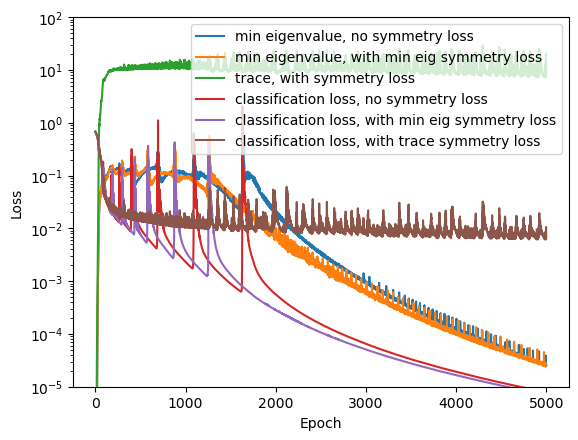

In [257]:
# plot the losses
plt.plot(losses_dict['min_eigen'], label='min eigenvalue, no symmetry loss')
plt.plot(losses_dict_symm['min_eigen'], label='min eigenvalue, with min eig symmetry loss')
plt.plot(losses_dict_trace['symm_loss'], label='trace, with symmetry loss')
plt.plot(losses_dict['classification_loss'], label='classification loss, no symmetry loss')
plt.plot(losses_dict_symm['classification_loss'], label='classification loss, with min eig symmetry loss')
plt.plot(losses_dict_trace['classification_loss'], label='classification loss, with trace symmetry loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(1e-5, 1e2)
plt.legend()
plt.show()

In [266]:
# train with eignvalues harmonic mean loss
def train_harmonic_mean(model, data, labels, n_epochs, lr, weight_decay=0, with_symm_loss=False):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.BCELoss()
    losses_dict = defaultdict(list)
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        output = model(data).squeeze()
        loss = criterion(output, labels)
        losses_dict['classification_loss'].append(loss.item())
        M = calculate_M(data, model, L)
        eigvals = torch.linalg.eigvalsh(M)
        harmonic_mean = 1 / torch.mean(1 / eigvals)
        losses_dict['harmonic_mean'].append(harmonic_mean.item())
        loss.backward()
        if with_symm_loss:
            (with_symm_loss*harmonic_mean).backward()
        optimizer.step()
        # print the loss and accuracy every 100 epochs
        if epoch % 300 == 0:
            accuracy = torch.sum(torch.round(output) == labels).float() / labels.shape[0]
            print(f"Epoch {epoch}, Loss: {loss.item()}, Accuracy: {accuracy.item()}, Harmonic Mean: {harmonic_mean}")
    return model, losses_dict

# train the model
model = Net(25, 8)
model2 = deepcopy(model)

print('Training model with small eig symmetry loss')
model, losses_dict = train_min_eigen(model, elipse_data, lables, 5000, 3e-3, 1e-3, with_symm_loss=1e-3)
print('\nTraining model with harmonic mean symmetry loss')
model2, losses_dict_symm = train_harmonic_mean(model2, elipse_data, lables, 5000, 3e-3, 1e-3, with_symm_loss=1e-3)

Training model with small eig symmetry loss
Epoch 0, Loss: 0.6451908946037292, Accuracy: 0.7411999702453613, Min Eigen: 5.851590878513946e-10
Epoch 300, Loss: 0.013046544045209885, Accuracy: 0.9954000115394592, Min Eigen: 0.16638101637363434
Epoch 600, Loss: 0.005335015710443258, Accuracy: 0.9983999729156494, Min Eigen: 0.12474393099546432
Epoch 900, Loss: 0.0030074536334723234, Accuracy: 0.9990000128746033, Min Eigen: 0.11711444705724716
Epoch 1200, Loss: 0.01810109242796898, Accuracy: 0.9948999881744385, Min Eigen: 0.1184530183672905
Epoch 1500, Loss: 0.0011651390232145786, Accuracy: 0.9998000264167786, Min Eigen: 0.13976158201694489
Epoch 1800, Loss: 0.0003848382330033928, Accuracy: 1.0, Min Eigen: 0.011144864372909069
Epoch 2100, Loss: 7.090882718330249e-05, Accuracy: 1.0, Min Eigen: 0.0012281218077987432
Epoch 2400, Loss: 2.7332995159667917e-05, Accuracy: 1.0, Min Eigen: 0.0003642020747065544
Epoch 2700, Loss: 1.4552760148944799e-05, Accuracy: 1.0, Min Eigen: 7.270013156812638e-05

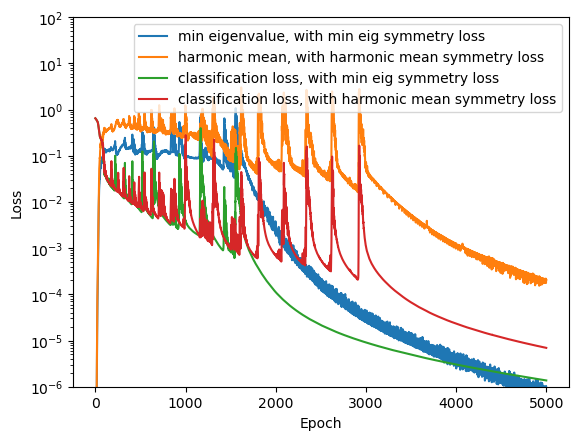

In [268]:
# plot the losses
plt.plot(losses_dict['min_eigen'], label='min eigenvalue, with min eig symmetry loss')
plt.plot(losses_dict_symm['harmonic_mean'], label='harmonic mean, with harmonic mean symmetry loss')
plt.plot(losses_dict['classification_loss'], label='classification loss, with min eig symmetry loss')
plt.plot(losses_dict_symm['classification_loss'], label='classification loss, with harmonic mean symmetry loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(1e-6, 1e2)
plt.legend()
plt.show()

In [273]:
# train the model
model = Net(25, 8)
model2 = deepcopy(model)

print('\nTraining model with trace symmetry loss')
model, losses_dict_trace = train(model, spherical_data, lables, 5000, 3e-3, 1e-3, with_symm_loss=1e-3)
# print('Training model with small eig symmetry loss')
# model, losses_dict = train_min_eigen(model, spherical_data, lables, 5000, 3e-3, 1e-3, with_symm_loss=1e-3)
print('\nTraining model with harmonic mean symmetry loss')
model2, losses_dict_symm = train_harmonic_mean(model2, spherical_data, lables, 5000, 3e-3, 1e-3, with_symm_loss=1e-3)



Training model with trace symmetry loss
Epoch 0, Loss: 0.6686040163040161, Accuracy: 0.7411999702453613, Symm Loss: 2.848161706481278e-09
Epoch 300, Loss: 0.00853746011853218, Accuracy: 0.996399998664856, Symm Loss: 0.5154812335968018
Epoch 600, Loss: 0.004956885706633329, Accuracy: 0.9984999895095825, Symm Loss: 0.43547093868255615
Epoch 900, Loss: 0.008867315016686916, Accuracy: 0.9962000250816345, Symm Loss: 0.9614298939704895
Epoch 1200, Loss: 0.0016407378716394305, Accuracy: 0.9995999932289124, Symm Loss: 0.365055114030838
Epoch 1500, Loss: 0.0036609137896448374, Accuracy: 0.9991000294685364, Symm Loss: 0.4471397399902344
Epoch 1800, Loss: 0.0006045718328095973, Accuracy: 0.9998999834060669, Symm Loss: 0.21257013082504272
Epoch 2100, Loss: 0.006117142271250486, Accuracy: 0.9980000257492065, Symm Loss: 0.46451327204704285
Epoch 2400, Loss: 8.314786828123033e-05, Accuracy: 1.0, Symm Loss: 0.006155842915177345
Epoch 2700, Loss: 3.087678487645462e-05, Accuracy: 1.0, Symm Loss: 0.0013

In [276]:
sumlos = [x.item() for x in losses_dict_trace['symm_loss']]

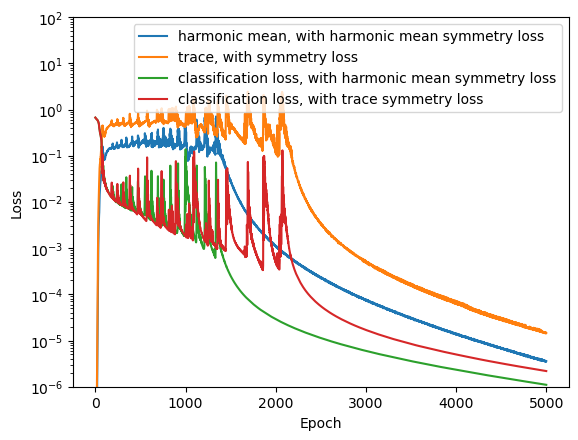

In [277]:
# plot the losses
# plt.plot(losses_dict['min_eigen'], label='min eigenvalue, with min eig symmetry loss')
plt.plot(losses_dict_symm['harmonic_mean'], label='harmonic mean, with harmonic mean symmetry loss')
plt.plot(sumlos, label='trace, with symmetry loss')
# plt.plot(losses_dict['classification_loss'], label='classification loss, with min eig symmetry loss')
plt.plot(losses_dict_symm['classification_loss'], label='classification loss, with harmonic mean symmetry loss')
plt.plot(losses_dict_trace['classification_loss'], label='classification loss, with trace symmetry loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(1e-6, 1e2)
plt.legend()
plt.show()